**Прогнозирование метеорологических данных**

In [119]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [120]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 0s 0us/step


In [121]:
df = pd.read_csv(csv_path)

In [123]:
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [125]:
# Определние признаков
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

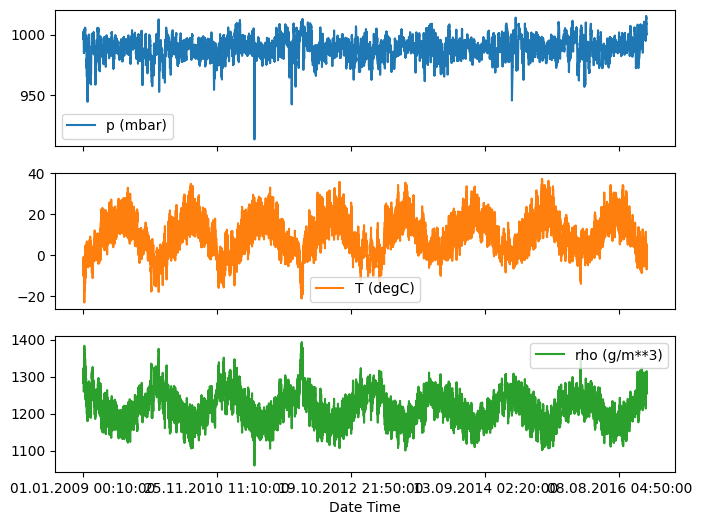

In [127]:
# Графики с динамикой признаков во времени
features.plot(subplots=True)

In [129]:
# Стандартизация данных
dataset = features[300000:].values
TRAIN_SPLIT = 85000
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [130]:
dataset = (dataset-data_mean)/data_std

In [131]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [132]:
past_history = 720
future_target = 72
STEP = 6

In [133]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [134]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [159]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [140]:
def create_time_steps(length):
  return list(range(-length, 0))

In [135]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

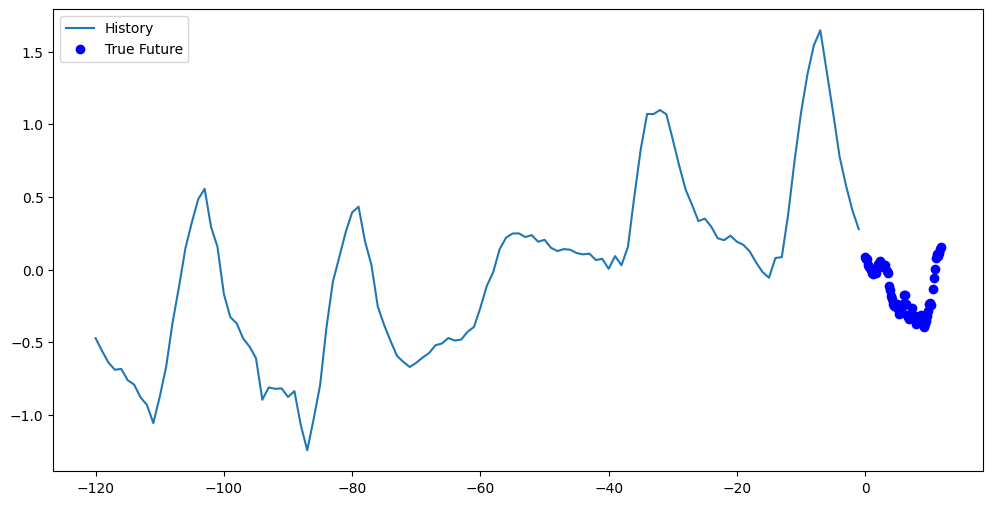

In [141]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [170]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
early_stop = EarlyStopping(monitor='val_mae', patience=5)

weather_model = tf.keras.models.Sequential()

weather_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_multi.shape[-2:],
               return_sequences=True))
weather_model.add(tf.keras.layers.LSTM(32, return_sequences=True))
weather_model.add(tf.keras.layers.Conv1D(64, 3, activation='linear'))
weather_model.add(tf.keras.layers.Conv1D(64, 1, activation='linear'))
weather_model.add(tf.keras.layers.Flatten())
weather_model.add(tf.keras.layers.Dense(72, activation='linear'))

weather_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
weather_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 120, 32)           4608      
                                                                 
 lstm_31 (LSTM)              (None, 120, 32)           8320      
                                                                 
 conv1d_10 (Conv1D)          (None, 118, 64)           6208      
                                                                 
 conv1d_11 (Conv1D)          (None, 118, 64)           4160      
                                                                 
 flatten_5 (Flatten)         (None, 7552)              0         
                                                                 
 dense_21 (Dense)            (None, 72)                543816    
                                                                 
Total params: 567,112
Trainable params: 567,112
Non-t

In [168]:
for x, y in val_data_multi.take(1):
  print (weather_model.predict(x).shape)

8/8 [==============================] - 1s 7ms/step
(256, 72)


In [171]:
callbacks = [checkpoint, early_stop]

model_history = weather_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                          callbacks=callbacks)

Epoch 1/100
199/200 [============================>.] - ETA: 0s - loss: 0.1496 - mae: 0.2995
Epoch 1: val_loss improved from inf to 0.11480, saving model to my_best_model.hdf5
200/200 [==============================] - 10s 21ms/step - loss: 0.1494 - mae: 0.2994 - val_loss: 0.1148 - val_mae: 0.2648
Epoch 2/100
199/200 [============================>.] - ETA: 0s - loss: 0.0998 - mae: 0.2451
Epoch 2: val_loss did not improve from 0.11480
200/200 [==============================] - 3s 15ms/step - loss: 0.0997 - mae: 0.2450 - val_loss: 0.1227 - val_mae: 0.2711
Epoch 3/100
199/200 [============================>.] - ETA: 0s - loss: 0.1034 - mae: 0.2460
Epoch 3: val_loss improved from 0.11480 to 0.09816, saving model to my_best_model.hdf5
200/200 [==============================] - 4s 18ms/step - loss: 0.1033 - mae: 0.2459 - val_loss: 0.0982 - val_mae: 0.2378
Epoch 4/100
198/200 [============================>.] - ETA: 0s - loss: 0.0848 - mae: 0.2211
Epoch 4: val_loss did not improve from 0.09816
2

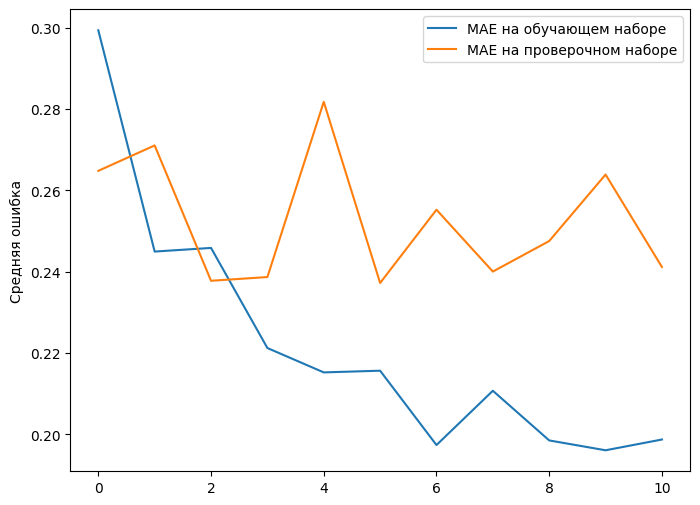

In [172]:
plt.plot(model_history.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(model_history.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [174]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [179]:
num_iterations = 5

Итерация №1...
Epoch 1/100
198/200 [============================>.] - ETA: 0s - loss: 0.0123 - mae: 0.0841
Epoch 1: val_loss did not improve from 0.09816
200/200 [==============================] - 4s 21ms/step - loss: 0.0123 - mae: 0.0842 - val_loss: 0.2265 - val_mae: 0.3642
Epoch 2/100
199/200 [============================>.] - ETA: 0s - loss: 0.0149 - mae: 0.0925
Epoch 2: val_loss did not improve from 0.09816
200/200 [==============================] - 3s 15ms/step - loss: 0.0149 - mae: 0.0925 - val_loss: 0.1971 - val_mae: 0.3454
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.0143 - mae: 0.0915
Epoch 3: val_loss did not improve from 0.09816
200/200 [==============================] - 4s 18ms/step - loss: 0.0143 - mae: 0.0915 - val_loss: 0.2172 - val_mae: 0.3526
Epoch 4/100
198/200 [============================>.] - ETA: 0s - loss: 0.0137 - mae: 0.0888
Epoch 4: val_loss did not improve from 0.09816
200/200 [==============================] - 3s 16ms/step - loss:

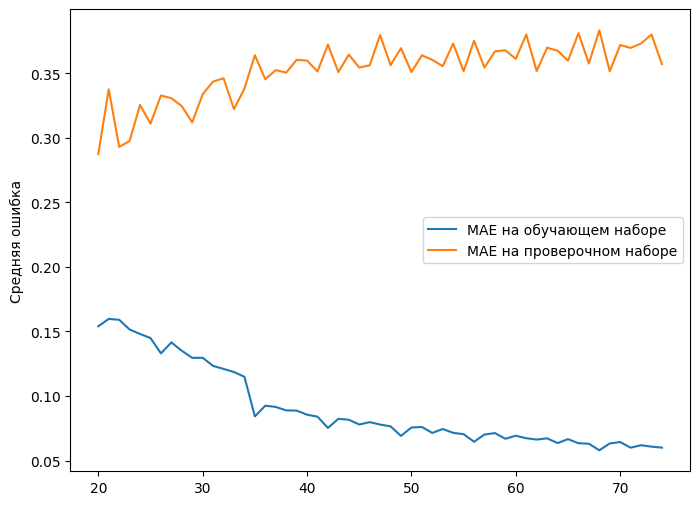

Итерация №6...
Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.0056 - mae: 0.0556
Epoch 1: val_loss did not improve from 0.09816
200/200 [==============================] - 4s 20ms/step - loss: 0.0056 - mae: 0.0556 - val_loss: 0.2336 - val_mae: 0.3807
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.0062 - mae: 0.0598
Epoch 2: val_loss did not improve from 0.09816
200/200 [==============================] - 3s 17ms/step - loss: 0.0062 - mae: 0.0598 - val_loss: 0.2078 - val_mae: 0.3584
Epoch 3/100
197/200 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0603
Epoch 3: val_loss did not improve from 0.09816
200/200 [==============================] - 3s 15ms/step - loss: 0.0064 - mae: 0.0603 - val_loss: 0.2279 - val_mae: 0.3761
Epoch 4/100
198/200 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0569
Epoch 4: val_loss did not improve from 0.09816
200/200 [==============================] - 4s 19ms/step - loss:

KeyboardInterrupt: ignored

In [178]:
for i,iteration in enumerate(range(num_iterations)):
  print(f'Итерация №{i+1}...')
  model_history = weather_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                          callbacks=callbacks)

  hist_val_2.extend(model_history.history['val_mae'][:])
  hist_train_2.extend(model_history.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [180]:
best_model = tf.keras.models.load_model(filepath)

8/8 [==============================] - 1s 9ms/step


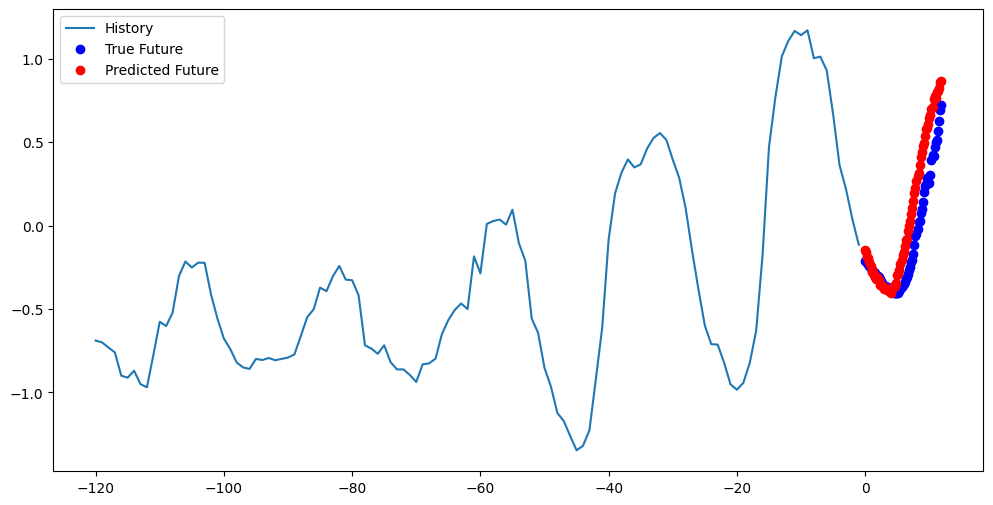

8/8 [==============================] - 0s 9ms/step


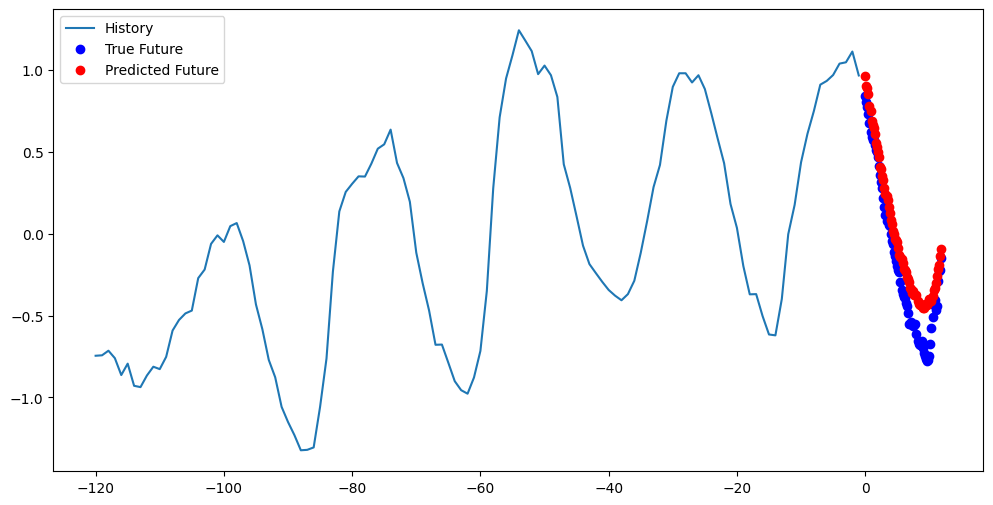

8/8 [==============================] - 0s 6ms/step


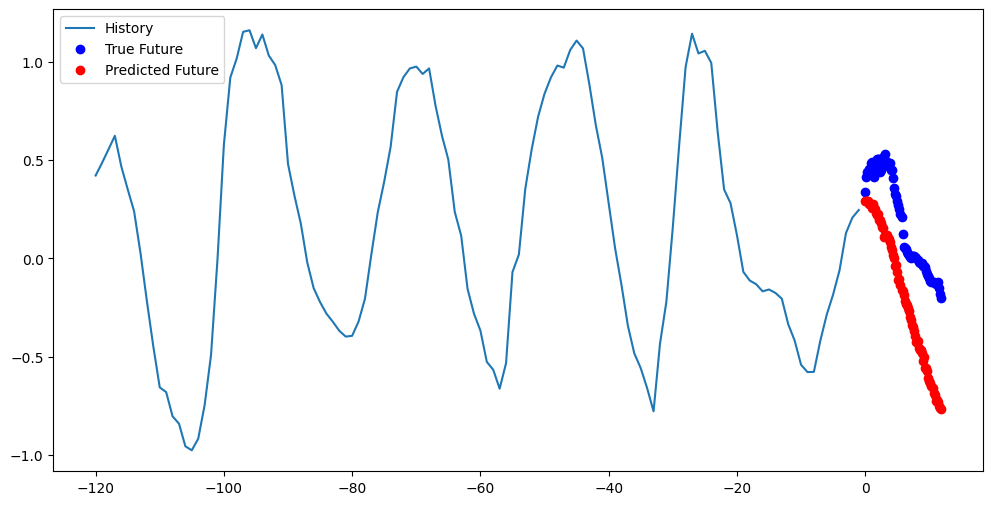

In [181]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], best_model.predict(x)[0])